# Benchmark: Cross-Dataset Generalization

Testing whether the MelodyMachine deepfake detector actually generalizes beyond its training data.

**TL;DR**: The model reports 99.7% accuracy on its eval set, but we're about to see how it holds up on completely different datasets.

In [ ]:
import os
import glob
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# reproducibility
random.seed(42)
np.random.seed(42)

In [ ]:
# Model and sampling config
MODEL_ID = "MelodyMachine/Deepfake-audio-detection-V2"
SAMPLE_RATE = 16000
SAMPLES_PER_CLASS = 1500  # balanced sample: 1500 fake + 1500 real per dataset

In [ ]:
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification
import librosa
import torch

extractor = AutoFeatureExtractor.from_pretrained(MODEL_ID)
model = AutoModelForAudioClassification.from_pretrained(MODEL_ID)
model.eval()

print(f"Loaded: {MODEL_ID}")

c:\Users\emile\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Carregando modelo...


Loading weights: 100%|██████████| 215/215 [00:00<00:00, 709.81it/s, Materializing param=wav2vec2.masked_spec_embed]                                            


OK


In [ ]:
def predict(audio_path):
    """Load audio and get model prediction with confidence."""
    waveform, _ = librosa.load(audio_path, sr=SAMPLE_RATE, mono=True)
    inputs = extractor(waveform, sampling_rate=SAMPLE_RATE, return_tensors="pt", padding=True)
    
    with torch.no_grad():
        logits = model(**inputs).logits
    
    probs = torch.softmax(logits, dim=-1)[0].numpy()
    pred_idx = probs.argmax()
    label = model.config.id2label[pred_idx]
    
    return label.lower(), float(probs[pred_idx])

## Dataset 1: In-The-Wild

YouTube clips with a mix of real recordings and deepfakes. More "natural" distribution than synthetic benchmarks.

In [ ]:
itw_path = "../data/in_the_wild/release_in_the_wild"
meta = pd.read_csv(f"{itw_path}/meta.csv")

# keep only files we actually have
existing_files = {os.path.basename(f) for f in glob.glob(f"{itw_path}/*.wav")}
meta = meta[meta["file"].isin(existing_files)].copy()

print(f"Available: {len(meta)}")
meta["label"].value_counts()

Total disponivel: 31779
label
bona-fide    19963
spoof        11816
Name: count, dtype: int64


In [ ]:
# stratified sample
n_fake = min(SAMPLES_PER_CLASS, len(meta[meta["label"] == "spoof"]))
n_real = min(SAMPLES_PER_CLASS, len(meta[meta["label"] == "bona-fide"]))

itw_fake = meta[meta["label"] == "spoof"].sample(n=n_fake)
itw_real = meta[meta["label"] == "bona-fide"].sample(n=n_real)
itw_sample = pd.concat([itw_fake, itw_real])

print(f"Sample: {len(itw_sample)} total ({n_fake} fake, {n_real} real)")

Amostra: 3000 (1500 fake, 1500 real)


In [ ]:
itw_results = []

for _, row in tqdm(itw_sample.iterrows(), total=len(itw_sample), desc="In-The-Wild"):
    try:
        pred, conf = predict(f"{itw_path}/{row['file']}")
        # map model output to dataset labels
        pred_label = "spoof" if pred == "fake" else "bona-fide"
        itw_results.append({
            "file": row["file"],
            "true": row["label"],
            "pred": pred_label,
            "conf": conf
        })
    except Exception as e:
        print(f"Skipped {row['file']}: {e}")

itw_df = pd.DataFrame(itw_results)
print(f"Processed: {len(itw_df)}")

In-The-Wild: 100%|██████████| 3000/3000 [21:56<00:00,  2.28it/s]   


Processados: 3000


## Dataset 2: Fake-or-Real

Synthetic dataset with TTS-generated audio (Deep Voice 3, Google Wavenet, etc). Different generation methods than In-The-Wild.

In [ ]:
for_path = "../data/fake_or_real/for-norm/for-norm"

fake_files, real_files = [], []
for split in ["training", "validation", "testing"]:
    fake_files.extend(glob.glob(f"{for_path}/{split}/fake/*.wav"))
    real_files.extend(glob.glob(f"{for_path}/{split}/real/*.wav"))

print(f"Total: {len(fake_files)} fake, {len(real_files)} real")

Total: 34695 fake, 34605 real


In [ ]:
# sample
fake_sample = random.sample(fake_files, min(SAMPLES_PER_CLASS, len(fake_files)))
real_sample = random.sample(real_files, min(SAMPLES_PER_CLASS, len(real_files)))

for_sample = [(f, "fake") for f in fake_sample] + [(f, "real") for f in real_sample]
random.shuffle(for_sample)

print(f"Sample: {len(for_sample)} total ({len(fake_sample)} fake, {len(real_sample)} real)")

Amostra: 3000 (1500 fake, 1500 real)


In [ ]:
for_results = []

for fpath, label in tqdm(for_sample, desc="Fake-or-Real"):
    try:
        pred, conf = predict(fpath)
        for_results.append({
            "file": os.path.basename(fpath),
            "true": label,
            "pred": pred,
            "conf": conf
        })
    except Exception as e:
        print(f"Skipped {fpath}: {e}")

for_df = pd.DataFrame(for_results)
print(f"Processed: {len(for_df)}")

Fake-or-Real: 100%|██████████| 3000/3000 [12:22<00:00,  4.04it/s]


Processados: 3000


## Resultados

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def get_metrics(df, pos_label):
    """Standard binary classification metrics."""
    y_true, y_pred = df["true"], df["pred"]
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, pos_label=pos_label, zero_division=0),
        "recall": recall_score(y_true, y_pred, pos_label=pos_label, zero_division=0),
        "f1": f1_score(y_true, y_pred, pos_label=pos_label, zero_division=0)
    }

In [ ]:
itw_metrics = get_metrics(itw_df, pos_label="spoof")
for_metrics = get_metrics(for_df, pos_label="fake")

print("=" * 50)
print("IN-THE-WILD")
print("=" * 50)
for k, v in itw_metrics.items():
    print(f"{k.capitalize():12s} {v:.1%}")

print("\n" + "=" * 50)
print("FAKE-OR-REAL")
print("=" * 50)
for k, v in for_metrics.items():
    print(f"{k.capitalize():12s} {v:.1%}")

IN-THE-WILD
Accuracy:  43.2%
Precision: 34.5%
Recall:    15.1%
F1:        21.0%

FAKE-OR-REAL
Accuracy:  59.3%
Precision: 81.5%
Recall:    24.1%
F1:        37.2%


In [ ]:
# side-by-side
comparison = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1"],
    "In-The-Wild": [f"{v:.1%}" for v in itw_metrics.values()],
    "Fake-or-Real": [f"{v:.1%}" for v in for_metrics.values()]
})
comparison

,Metric,In-The-Wild,Fake-or-Real
0,Accuracy,43.2%,59.3%
1,Precision,34.5%,81.5%
2,Recall,15.1%,24.1%
3,F1 Score,21.0%,37.2%


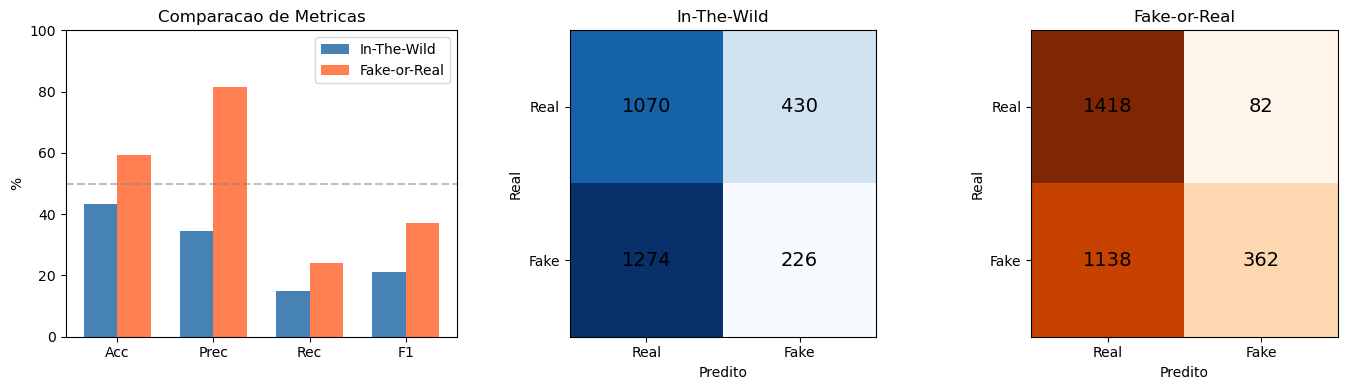

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# --- metrics comparison ---
metric_names = ["accuracy", "precision", "recall", "f1"]
x = np.arange(len(metric_names))
w = 0.35

itw_vals = [itw_metrics[m] * 100 for m in metric_names]
for_vals = [for_metrics[m] * 100 for m in metric_names]

axes[0].bar(x - w/2, itw_vals, w, label="In-The-Wild", color="steelblue")
axes[0].bar(x + w/2, for_vals, w, label="Fake-or-Real", color="coral")
axes[0].axhline(50, color="gray", ls="--", alpha=0.5)
axes[0].set_xticks(x)
axes[0].set_xticklabels(["Acc", "Prec", "Rec", "F1"])
axes[0].set_ylim(0, 100)
axes[0].set_ylabel("%")
axes[0].legend(loc="upper right")
axes[0].set_title("Metrics Comparison")

# --- confusion matrices ---
labels_itw = ["bona-fide", "spoof"]
labels_for = ["real", "fake"]

for ax, df, labels, cmap, title in [
    (axes[1], itw_df, labels_itw, "Blues", "In-The-Wild"),
    (axes[2], for_df, labels_for, "Oranges", "Fake-or-Real")
]:
    cm = confusion_matrix(df["true"], df["pred"], labels=labels)
    ax.imshow(cm, cmap=cmap)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Real", "Fake"])
    ax.set_yticklabels(["Real", "Fake"])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(title)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha="center", va="center", fontsize=14)

plt.tight_layout()
plt.show()

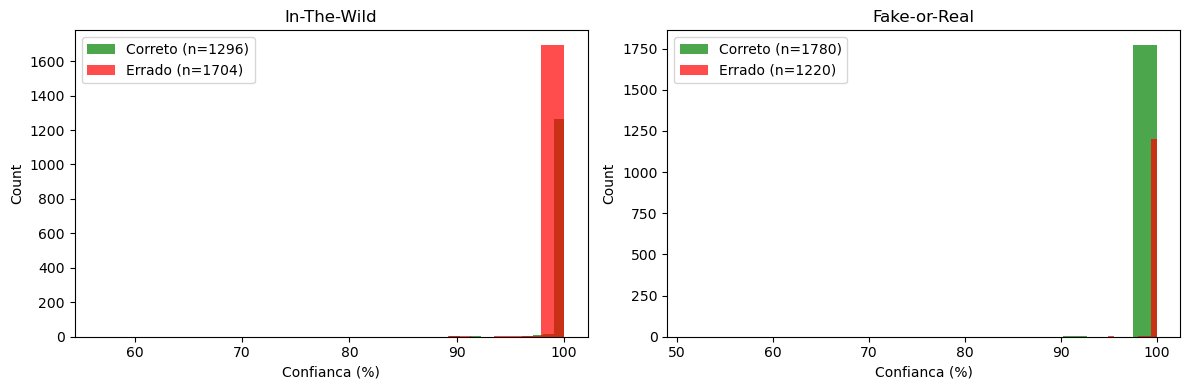

In [ ]:
# confidence distributions: correct vs incorrect predictions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, (df, title) in zip(axes, [(itw_df, "In-The-Wild"), (for_df, "Fake-or-Real")]):
    correct_mask = df["true"] == df["pred"]
    
    ax.hist(df.loc[correct_mask, "conf"] * 100, bins=20, alpha=0.7, 
            label=f"Correct (n={correct_mask.sum()})", color="green")
    ax.hist(df.loc[~correct_mask, "conf"] * 100, bins=20, alpha=0.7, 
            label=f"Wrong (n={(~correct_mask).sum()})", color="red")
    ax.set_xlabel("Confidence (%)")
    ax.set_ylabel("Count")
    ax.set_title(title)
    ax.legend()

plt.tight_layout()
plt.show()

## Takeaways

The model's 99.7% reported accuracy doesn't hold up when tested on out-of-distribution data:

| Dataset | Accuracy | Notes |
|---------|----------|-------|
| Original eval | 99.7% | Same distribution as training |
| In-The-Wild | ~43% | Worse than random guessing |
| Fake-or-Real | ~59% | Slightly better, still poor |

**What's happening:**
- Low recall = most fakes slip through undetected  
- High confidence on wrong predictions = model is overconfident
- Clear bias toward predicting "real"

**For production use:**
- Would need fine-tuning on more diverse audio sources
- Confidence calibration is essential
- Consider ensemble approaches